In [1]:
import pickle
import numpy as np
import yaml
import os
from matplotlib import pyplot as plt
from hsa_model import HSAPotential, save_potential

# read in all the data
data_folder = '/home/joseph/workspaces/hsa_hopper/hsa_hopper/data/hsa_identification'
experiment_configs = {}
hardware_configs = {}
data = {}
for rel_path in os.listdir(data_folder):
    path = os.path.join(data_folder, rel_path)
    if os.path.isdir(path):
        with open(os.path.join(path, 'experiment_config.yaml'), 'r') as f:
            experiment_configs[rel_path] = yaml.load(f, yaml.Loader)
        with open(os.path.join(path, 'hardware_config.yaml'), 'r') as f:
            hardware_configs[rel_path] = yaml.load(f, yaml.Loader)
        with open(os.path.join(path, 'data.pickle'), 'rb') as f:
            data[rel_path] = pickle.load(f)

In [2]:
print("FUCK YOU")

FUCK YOU


In [2]:
# def calculate_dynamics(x, t):
#     M = len(t)
#     A = np.zeros((3*(M-2), 2*(M-1)))
#     b = np.zeros((3*(M-2)))
#     for i in range(0,M-2):
#         dt = t[i]-t[i-1]
#         A[3*i, 2*i] = dt
#         A[3*i, 2*i+1] = .5*dt**2
#         b[3*i] = x[i]-x[i+1]

#         dt = t[i+1]-t[i]
#         A[3*i+1, 2*i] = 1
#         A[3*i+1, 2*i+1] = dt
#         A[3*i+1, 2*i+2] = -1
#         b[3*i+1] = 0.

#         A[3*i+2, 2*i] = -dt
#         A[3*i+2, 2*i+1] = .5*dt**2
#         b[3*i+2] = x[i+1]-x[i+2]
    
#     coeffs, error, rank, sigma = np.linalg.lstsq(A,b)
#     xdot = coeffs[0:-2:2]
#     xddot = coeffs[1:-1:2]
#     return xdot, xddot

# what is the band structure of this matrix?
# upper-diagonal zeros is 2(M-1) - 3
# lower-diagonal zeros is 

from scipy.sparse import bsr_array
from scipy.optimize import lsq_linear
def calculate_dynamics(x,t):
    M = len(t)
    A_rows = np.hstack([np.array([3*i, 3*i, 3*i+1, 3*i+1, 3*i+1, 3*i+2, 3*i+2]) for i in range(0,M-2)])
    A_cols = np.hstack([np.array([2*i, 2*i+1, 2*i, 2*i+1, 2*i+2, 2*i, 2*i+1]) for i in range(0,M-2)])
    A_data = []
    b = np.zeros(3*(M-2))
    for i in range(M-2):
        dt = t[i]-t[i-1]
        A_data.append([dt, .5*dt**2, 1, dt, -1, -dt, .5*dt**2])
        b[3*i] = x[i]-x[i+1]
        b[3*i+1] = 0.
        b[3*i+2] = x[i+1]-x[i+2]
    data = np.hstack(A_data)
    A_sparse = bsr_array((data,(A_rows,A_cols)), shape=(3*(M-2),2*(M-1)))
    result = lsq_linear(A_sparse, b)
    xdot = result.x[0:-2:2]
    xddot = result.x[1:-1:2] 
    return xdot, xddot


In [3]:
key = list(data.keys())[0]
experiment = data[key]
N_trials = len(experiment['times'])
x = []
t = []
xdot = []
xddot = []
torque = []
l = []
dldx = []
psi = []
skip = 80
for i in range(N_trials):
    _x = experiment['motor_angle'][i][0:-1:skip]
    _t = experiment['times'][i][0:-1:skip]
    _tau = experiment['motor_torque'][i][0:-1:skip]
    _l = experiment['hsa_len'][i][0:-1:skip]
    _dl_dx = experiment['dldtheta'][i][0:-1:skip]
    _xdot, _xddot = calculate_dynamics(_x,_t)
    x.append(_x[1:-1])
    t.append(_t[1:-1])
    torque.append(_tau[1:-1])
    l.append(_l[1:-1])
    dldx.append(_dl_dx[1:-1])
    psi.append(experiment['hsa_angle'][i]*(np.pi/180)*np.ones(len(_x)))
    xdot.append(_xdot)
    xddot.append(_xddot)


In [4]:
# pick 5 lengths uniformly from each trial
y = np.vstack(tuple([[_l, psi[i][0]] for _l in np.linspace(min(l[i]), max(l[i]), len(psi))] for i in range(len(psi))))
print(y.shape)

(144, 2)


In [43]:
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
N = y.shape[0]
M = sum(len(t[i]) for i in range(len(t)))
s = 2/np.sqrt(2) # length scale for the Gaussian process regressor
# s = 2*np.sqrt(2)
# s = 1
v = np.zeros(y.shape[0])
potential = HSAPotential(v, y, s)

# stack all the data for access by a common index
_x = np.hstack(x)
_t = np.hstack(t)
_xdot = np.hstack(xdot)
_xddot = np.hstack(xddot)
_l = np.hstack(l)
_dldx = np.hstack(dldx)
_tau = np.hstack(torque)
_psi = np.hstack(psi)
# thats a pretty damn big system of equations
# lets assemble the A-matrix and b-vector
A = np.zeros((M,2+N))
b = np.zeros((M))
for i in range(M):
    b[i] = _tau[i]
    A[i,0] = -_xddot[i]
    A[i,1] = -_xdot[i]
    for j in range(N):
        z = np.array([_l[i], _psi[i]])
        A[i,2+j] = _dldx[i]*(potential.dk(z, j)[0])
ATA = A.T@A
ATb = A.T@_tau
bTb = _tau.T@_tau
f = lambda x: x.T@ATA@x+bTb-2*x.T@ATb
jac = lambda x: 2*ATA@x-2*ATb
hess = lambda x: 2*ATA

# next constraints - enforce positive weights
# and positive definiteness of stiffness at collocation points
C = np.zeros((2+N,2+N))
C[0,0] = 1
C[1,1] = 1
lb = np.zeros(2+N)
for j in range(N):
    z = y[j,:]
    K = [(potential.drho(z,k)@potential.drho(z,k).T-potential.d2rho(z,k))[0,0] for k in range(N)] 
    C[2+j,2:] = K

constraints = [LinearConstraint(C,lb=lb)]

x0 = np.zeros(2+N)
result = minimize(f, x0, jac=jac, hess=hess, constraints=constraints, method='trust-constr')

In [44]:
potential.v = result.x[2:]
print(result)

           message: `xtol` termination condition is satisfied.
           success: True
            status: 2
               fun: 134.68069880332405
                 x: [ 1.094e-02  4.315e-03 ... -1.360e+02  9.161e+01]
               nit: 897
              nfev: 1002
              njev: 792
              nhev: 792
          cg_niter: 59421
      cg_stop_cond: 2
              grad: [ 1.009e-03 -3.914e-02 ... -2.333e-04 -1.644e-03]
   lagrangian_grad: [ 1.207e-07 -7.289e-07 ...  6.386e-04 -8.488e-04]
            constr: [array([ 1.094e-02,  4.315e-03, ...,  1.121e+04,
                            2.369e+01])]
               jac: [array([[ 1.000e+00,  0.000e+00, ...,  0.000e+00,
                             0.000e+00],
                           [ 0.000e+00,  1.000e+00, ...,  0.000e+00,
                             0.000e+00],
                           ...,
                           [ 0.000e+00,  0.000e+00, ..., -1.979e+03,
                            -1.810e+03],
                       

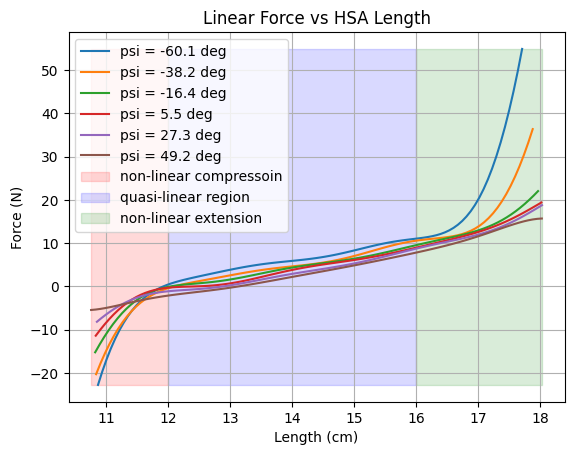

In [48]:
# plot this potential function for a range of theta values, fix psi = 0.

# for i in range(len(psi)):
fig, ax = plt.subplots()
# for i in range(len(psi)):
for i in range(0,len(psi),2):
    _psi = psi[i][0]
    hsa_lens = np.linspace(min(l[i]), max(l[i]), 100)
    z = np.array([[l, _psi] for l in hsa_lens])
    ax.plot(z[:,0]*100, [potential.dV(z[i,:])[0] for i in range(len(hsa_lens))], label=f'psi = {(_psi*180/np.pi):.1f} deg')
ax.set_title('Linear Force vs HSA Length')
ax.set_xlabel('Length (cm)')
ax.set_ylabel('Force (N)')

xmin = min(min(line.get_xdata()) for line in ax.lines)
xmax = max(max(line.get_xdata()) for line in ax.lines)
ymin = min(min(line.get_ydata()) for line in ax.lines)
ymax = max(max(line.get_ydata()) for line in ax.lines)
ax.fill_between([xmin, 12], [ymin, ymin], [ymax, ymax], color='r', alpha=.15, label='non-linear compressoin')
ax.fill_between([12,16], [ymin, ymin], [ymax, ymax], color='b', alpha=.15, label='quasi-linear region')
ax.fill_between([16,xmax], [ymin, ymin], [ymax, ymax], color='g', alpha=.15, label='non-linear extension')
ax.grid()
ax.legend()

0
2
4
6
8
10


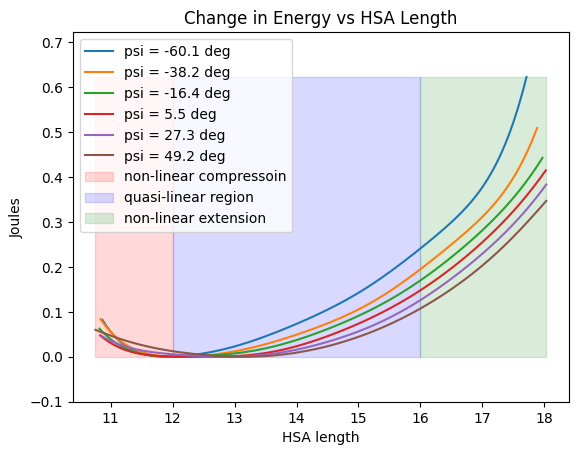

In [49]:
fig, ax = plt.subplots()
# for i in range(len(psi)):
for i in range(0,len(psi),2):
    print(i)
    _psi = psi[i][0]
    hsa_lens = np.linspace(min(l[i]), max(l[i]), 100)
    z = np.array([[l, _psi] for l in hsa_lens])
    ax.plot(100*z[:,0], [potential.V(z[i,:]) for i in range(len(hsa_lens))], label=f'psi = {(_psi*180/np.pi):.1f} deg')
ax.set_title('Change in Energy vs HSA Length')
ax.set_xlabel('HSA length')
ax.set_ylabel('Joules')
for i, line in enumerate(ax.lines):
    ydata = np.array(line.get_ydata())
    ydata -= np.min(ydata)
    line.set_ydata(ydata)
ymin = min(min(line.get_ydata()) for line in ax.lines)
ymax = max(max(line.get_ydata()) for line in ax.lines)
ax.fill_between([xmin, 12], [ymin, ymin], [ymax, ymax], color='r', alpha=.15, label='non-linear compressoin')
ax.fill_between([12,16], [ymin, ymin], [ymax, ymax], color='b', alpha=.15, label='quasi-linear region')
ax.fill_between([16,xmax], [ymin, ymin], [ymax, ymax], color='g', alpha=.15, label='non-linear extension')
ax.set_ylim([ymin-.1, ymax+.1])
# ax.legend(loc=[.35,.45])
ax.legend()

In [102]:
# print an energy heatmap
l_vec = np.linspace(.16,.18,20)
psi_vec = np.linspace(-61*np.pi/180,-30*np.pi/180, 20)
X,Y  = np.meshgrid(l_vec,psi_vec)
# Z1 = np.array([[ potential.V(np.array([X[i,j],Y[i,j]])) for j in range(X.shape[1])] for i in range(X.shape[0])])
Z2 = np.array([[ potential.dV(np.array([X[i,j],Y[i,j]]))[0] for j in range(X.shape[1])] for i in range(X.shape[0])])
Z3 = np.array([[ potential.d2V(np.array([X[i,j],Y[i,j]]))[0,0] for j in range(X.shape[1])] for i in range(X.shape[0])])
Z3 = np.clip(Z3, 1, np.inf)

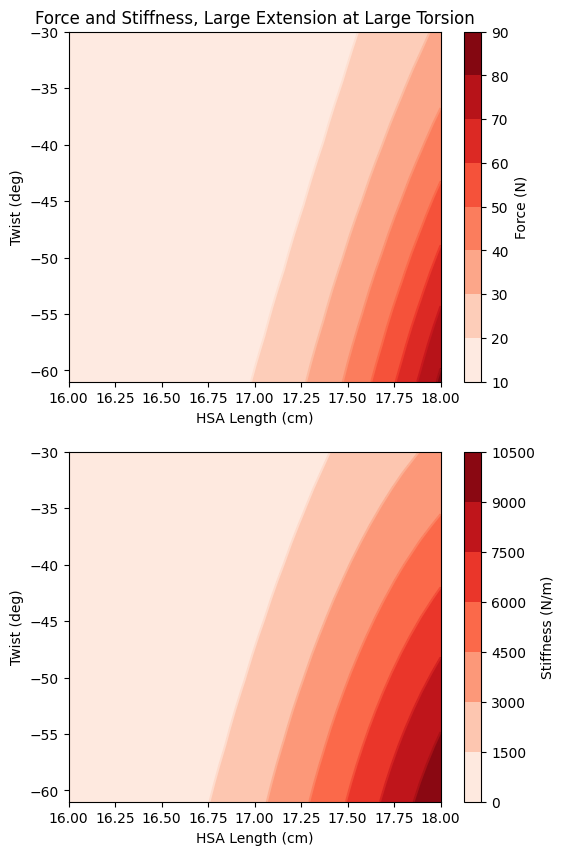

In [104]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(6,10))
CS11 = ax[0].contour(100*X,180*Y/np.pi,Z2, cmap='Reds')
CS12 = ax[0].contourf(100*X,180*Y/np.pi,Z2, cmap='Reds')
CS21 = ax[1].contour(100*X,180*Y/np.pi,Z3, cmap='Reds',)
CS22 = ax[1].contourf(100*X,180*Y/np.pi,Z3, cmap='Reds',)
ax[0].set_title('Force and Stiffness, Large Extension at Large Torsion')
ax[0].set_ylabel('Twist (deg)')
ax[1].set_ylabel('Twist (deg)')
ax[0].set_xlabel('HSA Length (cm)')
ax[1].set_xlabel('HSA Length (cm)')
fig.colorbar(CS12, label='Force (N)')
fig.colorbar(CS22, label='Stiffness (N/m)')

In [105]:
from scipy.optimize import root_scalar
# code to find rest length of HSA as a function of twist

def R(psi, bracket):
    f = lambda l, psi: potential.dV(np.array([l, psi]))[0]
    sol = root_scalar(f, (psi,), method='bisect', bracket=bracket, xtol = 1e-9)
    return sol.root

In [106]:
from scipy.optimize import minimize, LinearConstraint
omega = (5*np.pi)
mass = np.array([1.2, 1.8, 2.2])
E = np.array([m*9.81*.04 for m in mass])
K_sys = np.array([m*omega**2 for m in mass])
K_ground = np.array([10000, 5000, 2000, 1000])
K_leg = np.array([[1/(1/K1-1/K2) for K2 in K_ground] for K1 in K_sys])
dx = np.array([
    [np.sqrt(2*E[i]/K_leg[i,j]/(1+K_leg[i,j]/K_ground[j])) for j in range(len(K_ground))] 
    for i in range(len(E))
])
E_leg = np.array([
    [.5*K_leg[i,j]*dx[i,j]**2 for j in range(dx.shape[1])]
    for i in range(dx.shape[0])
])

# lots and lots of analysis
def F(z, dx, E_leg):
    # get rest length
    l0 = z[0]
    l1 = l0 + dx
    z0 = np.array([l0, z[1]])
    z1 = np.array([l1, z[1]])
    E = potential.V(z1)-potential.V(z0)
    f = (E - E_leg)**2

    # calculate gradient wrt psi
    dE = potential.dV(z1)-potential.dV(z0)
    return f, 2*(E-E_leg)*dE

result = np.zeros((2,*dx.shape))
for i in range(dx.shape[0]):
    for j in range(dx.shape[1]):
        z0 = [R(0., [.11,.18]),10*np.pi/180]
        constraints = [
            LinearConstraint(np.array([1,0]),lb=.1,ub=.1825-dx[i,j]),
            LinearConstraint(np.array([0,1]),lb=-60*np.pi/180,ub=np.pi/4)
        ]
        sol = minimize(F,z0,args=(dx[i,j],E_leg[i,j]),method='SLSQP',jac=True,constraints=constraints)
        result[:,i,j] = sol.x
        print(sol)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.6232717303583633e-06
       x: [ 1.278e-01  1.561e-01]
     nit: 2
     jac: [-5.356e-02  1.974e-04]
    nfev: 2
    njev: 2
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 2.7628362992824103e-08
       x: [ 1.288e-01  1.535e-01]
     nit: 4
     jac: [-6.767e-03  2.523e-05]
    nfev: 4
    njev: 4
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 6.734207134131243e-08
       x: [ 1.319e-01  1.521e-01]
     nit: 5
     jac: [ 9.331e-03 -3.656e-05]
    nfev: 5
    njev: 5
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.124674699996414e-08
       x: [ 1.368e-01  1.501e-01]
     nit: 6
     jac: [-2.882e-03  1.208e-05]
    nfev: 6
    njev: 6
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 3.8441493774972785e-08
       x: [ 1.283e-01 -7.004e-01]
     nit: 6
     

In [107]:
# print(sol.x*180/np.pi)
# print(R(sol.x, [.1,.18])+dx[1,2])
print(result[0,:,:])
print(result[0,:,:]+dx)
print(result[1,:,:]*180/np.pi)

[[0.12777239 0.12883542 0.13186904 0.1367511 ]
 [0.12829071 0.13107515 0.1379175  0.15115046]
 [0.12916394 0.13222536 0.14112236 0.15609805]]
[[0.1825     0.18189317 0.1799172  0.17644995]
 [0.18218339 0.18246304 0.18179101 0.1825    ]
 [0.1825     0.1825     0.18221276 0.18188138]]
[[  8.94581211   8.79238923   8.71390606   8.5972381 ]
 [-40.12715878 -36.81581029 -32.96783482  -7.58317185]
 [-45.         -45.         -40.11192646 -25.74762728]]
